# Импорт библиотек и загрузка файлов

In [20]:
import os
import scipy
import scipy.stats as stats

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.io as pio
# from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
# from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (mean_squared_error, mean_absolute_error, r2_score,
                             confusion_matrix, precision_score, recall_score, f1_score, fbeta_score)
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Conv1D, Flatten, Dense, Dropout, BatchNormalization, Input,
                                     Concatenate, Reshape, LSTM, MaxPooling1D, Conv2D, MaxPool2D)
from tensorflow.keras.optimizers import Adam

from modules.data_transformation import *
from modules.model_evaluation import (evaluate_regression_model, evaluate_classification_model, plot_learning_curves)

In [3]:
pio.renderers.default = "notebook"

In [4]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

### Сейчас не нужно

In [5]:
# # Объединяем данные из эксель файла в один датафрейм, добавляя столбец cell_line (название листа в файле)
# file_path="data/4_cell_lines.xlsx"
# sheets = pd.ExcelFile(file_path).sheet_names

# df_list = []

# for sheet in sheets:
#     df = pd.read_excel(file_path, sheet_name=sheet)
#     df["cell_line"] = sheet
#     df_list.append(df)

# final_df = pd.concat(df_list, ignore_index=True)

# print(final_df.head())

# final_df.to_csv("data/4_cell_lines.csv", index=False, header=True)

In [6]:
# df = pd.read_csv("data/HEK293t.txt", sep=",", engine="python")

# df4 = pd.read_csv(r"data/II4.txt", sep=",", engine="python", names=['target', 'potential_off_target', 'is_off_target']) 

# K562_with_extra_features

In [ ]:
# df = pd.read_csv("data/K562.txt", sep=",", engine="python",
#                  names=['target', 'potential_off_target', 'is_off_target']
#                  )

# df['encoded_7channels'] = df.apply(
#     lambda row: encode_7channels(
#         row['target'],
#         row['potential_off_target'],
#         pam_location="last",
#         pam_length=3
#     ).flatten(),
#     axis=1
# )

# df['mismatch_count'] = df.apply(
#     lambda row: count_mismatches(row['target'], row['potential_off_target']),
#     axis=1
# )

# df['gc_target'] = df['target'].apply(calc_gc_content)
# df['gc_off_target'] = df['potential_off_target'].apply(calc_gc_content)

In [37]:
df = pd.read_csv(r"data/K562_with_extra_features.csv", sep=",", engine="python")
df.drop(columns=df.columns[0], axis=1, inplace=True)
df['encoded_7channels'] = df['encoded_7channels'].apply(lambda x: np.fromstring(x.strip("[]"), sep=' '))

In [19]:
df.mismatch_count.value_counts()

mismatch_count
6    16070
5     3547
4      608
3       76
2       13
1        4
7        1
Name: count, dtype: int64

In [11]:
df[df.is_off_target == 1].mismatch_count.value_counts()

mismatch_count
4    71
3    32
2    12
1     4
7     1
Name: count, dtype: int64

In [ ]:
# # Генерируем эмбеддинги для target
# target_embeddings = generate_embeddings(df, sequence_column='target', polymer_type='DNA', encoding_strategy='aptamer')
# target_embeddings.to_csv(r'data/target_embeddings.csv', header=True)

# # Генерируем эмбеддинги для potential_off_target
# off_target_embeddings = generate_embeddings(df, sequence_column='potential_off_target',
#                                                polymer_type='DNA', encoding_strategy='aptamer')
# off_target_embeddings.to_csv(r'data/off_target_embeddings.csv', header=True)

# # Объединяем с исходным DataFrame
# df = df.join(target_embeddings.add_prefix('target_'), how='left')
# df = df.join(off_target_embeddings.add_prefix('off_target_'), how='left')

In [ ]:
target_embeddings = pd.read_csv("data/target_embeddings.csv", index_col=0)
off_target_embeddings = pd.read_csv("data/off_target_embeddings.csv", index_col=0)

df = df.join(target_embeddings.add_prefix('target_'), how='left')
df = df.join(off_target_embeddings.add_prefix('off_target_'), how='left')

# MMgRNA

In [7]:
df = pd.read_csv(r"data/Table_S8_machine_learning_input.csv", engine="python", sep='\t')

In [8]:
df.rename(columns={
    "perfect match sgRNA": "perfect_match_sgRNA",
    "sgRNA sequence": "sgRNA_sequence",
    "mismatch position": "mismatch_position",
    "new pairing": "new_pairing",
    "mean relative gamma": "mean_relative_gamma",
    "genome input": "genome_input",
    "sgRNA input": "sgRNA_input"
}, inplace=True)

In [9]:
# df['encoded_or'] = df.apply(
#     lambda row: encode_or(
#         row['genome_input'],
#         row['sgRNA_input']
#     ).flatten(),
#     axis=1
# )

df['encoded_7channels'] = df.apply(
    lambda row: encode_7channels_mmrna(
        row['genome_input'],
        row['sgRNA_input']
    ).flatten(),
    axis=1
)

df['mismatch_count'] = df.apply(
    lambda row: count_mismatches(row['genome_input'], row['sgRNA_input']),
    axis=1
)

df['gc_genome'] = df['genome_input'].apply(calc_gc_content)
df['gc_sgrna'] = df['sgRNA_input'].apply(calc_gc_content)

df['pam'] = df['sgRNA_input'].apply(pam_mmrna)

In [10]:
df[df.mismatch_count==2]

,Unnamed: 0,perfect_match_sgRNA,gene,sgRNA_sequence,mismatch_position,new_pairing,K562,Jurkat,mean_relative_gamma,genome_input,sgRNA_input,encoded_7channels,mismatch_count,gc_genome,gc_sgrna,pam
13,AARS2_+_44281027.23-P1P2_01,AARS2_+_44281027.23-P1P2,AARS2,GAATGGCAGCTGCAGCCCGG,-18.0,rA:dC,True,False,0.679875,GTCAGTGGCAGCTGCAGCCCGGAGGC,GTGAATGGCAGCTGCAGCCCGGAGGC,"[0, 0, 0, -1, 1, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0...",2,0.730769,0.692308,AGG
14,AARS2_+_44281027.23-P1P2_02,AARS2_+_44281027.23-P1P2,AARS2,GAGAGGCAGCTGCAGCCCGG,-17.0,rA:dA,True,False,0.819009,GTCAGTGGCAGCTGCAGCCCGGAGGC,GTGAGAGGCAGCTGCAGCCCGGAGGC,"[0, 0, 0, -1, 0, 1, 0, 0, 0, -1, 0, 0, 0, 0, 0...",2,0.730769,0.730769,AGG
15,AARS2_+_44281027.23-P1P2_03,AARS2_+_44281027.23-P1P2,AARS2,GAGTGGCGGCTGCAGCCCGG,-13.0,rG:dT,True,False,0.896126,GTCAGTGGCAGCTGCAGCCCGGAGGC,GTGAGTGGCGGCTGCAGCCCGGAGGC,"[0, 0, 0, -1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,...",2,0.730769,0.769231,AGG
16,AARS2_+_44281027.23-P1P2_04,AARS2_+_44281027.23-P1P2,AARS2,GAGTGGCAGCCGCAGCCCGG,-10.0,rC:dA,True,False,0.051388,GTCAGTGGCAGCTGCAGCCCGGAGGC,GTGAGTGGCAGCCGCAGCCCGGAGGC,"[0, 0, 0, -1, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0...",2,0.730769,0.769231,AGG
17,AARS2_+_44281027.23-P1P2_05,AARS2_+_44281027.23-P1P2,AARS2,GAGTGGCAGCTCCAGCCCGG,-9.0,rC:dC,True,False,-0.138016,GTCAGTGGCAGCTGCAGCCCGGAGGC,GTGAGTGGCAGCTCCAGCCCGGAGGC,"[0, 0, 0, -1, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0...",2,0.730769,0.730769,AGG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26243,ZWINT_+_58121021.23-P1P2_10,ZWINT_+_58121021.23-P1P2,ZWINT,GAATCTTAGGGATAGTGGGA,-7.0,rA:dA,True,False,-0.027697,AGTAATCTTAGGGATTGTGGGAAGGC,AGGAATCTTAGGGATAGTGGGAAGGC,"[-1, 0, 0, -1, -1, 0, 0, 0, 0, -1, 0, 0, 0, -1...",2,0.461538,0.500000,AGG
26244,ZWINT_+_58121021.23-P1P2_11,ZWINT_+_58121021.23-P1P2,ZWINT,GAATCTTAGGGATCGTGGGA,-7.0,rC:dA,True,False,0.055466,AGTAATCTTAGGGATTGTGGGAAGGC,AGGAATCTTAGGGATCGTGGGAAGGC,"[-1, 0, 0, -1, -1, 0, 0, 0, 0, -1, 0, 0, 0, -1...",2,0.461538,0.538462,AGG
26245,ZWINT_+_58121021.23-P1P2_12,ZWINT_+_58121021.23-P1P2,ZWINT,GAATCTTAGGGATTGAGGGA,-5.0,rA:dA,True,False,0.097816,AGTAATCTTAGGGATTGTGGGAAGGC,AGGAATCTTAGGGATTGAGGGAAGGC,"[-1, 0, 0, -1, -1, 0, 0, 0, 0, -1, 0, 0, 0, -1...",2,0.461538,0.500000,AGG
26246,ZWINT_+_58121021.23-P1P2_13,ZWINT_+_58121021.23-P1P2,ZWINT,GAATCTTAGGGATTGTGAGA,-3.0,rA:dC,True,False,0.042555,AGTAATCTTAGGGATTGTGGGAAGGC,AGGAATCTTAGGGATTGTGAGAAGGC,"[-1, 0, 0, -1, -1, 0, 0, 0, 0, -1, 0, 0, 0, -1...",2,0.461538,0.461538,AGG


In [11]:
# # Генерируем эмбеддинги для genome input
# genome_embeddings = generate_embeddings(df, sequence_column='genome input', polymer_type='DNA', encoding_strategy='aptamer')
# genome_embeddings.to_csv(r'data/genome_embeddings.csv', header=True)

# # Генерируем эмбеддинги для sgRNA input
# sgRNA_embeddings = generate_embeddings(df, sequence_column='sgRNA input',
#                                                polymer_type='DNA', encoding_strategy='aptamer')
# sgRNA_embeddings.to_csv(r'data/sgRNA_embeddings.csv', header=True)

# # Объединяем с исходным DataFrame
# df = df.join(genome_embeddings.add_prefix('genome_'), how='left')
# df = df.join(sgRNA_embeddings.add_prefix('sgrna_'), how='left')

In [12]:
genome_embeddings = pd.read_csv("data/genome_embeddings.csv", index_col=0)
sgRNA_embeddings = pd.read_csv("data/sgRNA_embeddings.csv", index_col=0)

df = df.join(genome_embeddings.add_prefix('genome_'), how='left')
df = df.join(sgRNA_embeddings.add_prefix('sgrna_'), how='left')

# Regression

### CNN from ExsgRNA (encoded_7channels)

In [48]:
# Преобразуем encoded_7channels обратно в матрицу 7×N (для CNN можно оставить 2D)
X = np.array([np.reshape(ch, (7, -1)).T for ch in df['encoded_7channels']])
# Добавляем ось каналов: теперь (N, 26, 7, 1)
X = np.expand_dims(X, axis=-1)

# Целевая переменная
y = df['mean_relative_gamma'].to_numpy()

# Разделяем на train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [49]:
#############  float weights ##################

sample_weights_f=[]
class_weights_f={}
class_number_f=[0,0,0,0,0,0]
for i in range(0,len(y_train)):
	if y_train[i] <= 0.2:
		class_number_f[0]=class_number_f[0]+1
	elif y_train[i] > 0.2 and y_train[i] <= 0.4 :
		class_number_f[1]=class_number_f[1]+1
	elif y_train[i] > 0.4 and y_train[i] <= 0.6 :
		class_number_f[2]=class_number_f[2]+1
	elif y_train[i] > 0.6 and y_train[i] <= 0.8 :
		class_number_f[3]=class_number_f[3]+1
	elif y_train[i] > 0.8 and y_train[i] <= 1.0 :
		class_number_f[4]=class_number_f[4]+1
	elif y_train[i] > 1.0:
		class_number_f[5]=class_number_f[5]+1

print(class_number_f)

class_bin_f=[1/float(class_number_f[0]),1/float(class_number_f[1]),1/float(class_number_f[2]),
			 1/float(class_number_f[3]),1/float(class_number_f[4]),1/float(class_number_f[5])]

class_weights_f['0']=class_bin_f[0]/sum(class_bin_f)
class_weights_f['1']=class_bin_f[1]/sum(class_bin_f)
class_weights_f['2']=class_bin_f[2]/sum(class_bin_f)
class_weights_f['3']=class_bin_f[3]/sum(class_bin_f)
class_weights_f['4']=class_bin_f[4]/sum(class_bin_f)	
class_weights_f['5']=class_bin_f[5]/sum(class_bin_f)

print(class_weights_f)
	
for i in range(0,len(y_train)):
	if y_train[i] <= 0.2:
		sample_weights_f.append(class_weights_f['0'])
	elif y_train[i] > 0.2 and y_train[i] <= 0.4 :
		sample_weights_f.append(class_weights_f['1'])
	elif y_train[i] > 0.4 and y_train[i] <= 0.6 :
		sample_weights_f.append(class_weights_f['2'])
	elif y_train[i] > 0.6 and y_train[i] <= 0.8 :
		sample_weights_f.append(class_weights_f['3'])
	elif y_train[i] > 0.8 and y_train[i] <= 1.0 :
		sample_weights_f.append(class_weights_f['4'])
	elif y_train[i] > 1.0:
		sample_weights_f.append(class_weights_f['5'])	

sample_weights_f=np.array(sample_weights_f)

[12968, 1552, 1518, 1773, 1766, 1421]
{'0': 0.023991308015249593, '1': 0.20046345511711128, '2': 0.20495341392737598, '3': 0.17547618857403088, '4': 0.17617173405535488, '5': 0.21894390031087735}


In [50]:
# Создаём модель
model_float = Sequential()

# 1) Первый сверточный слой
model_float.add(Conv2D(
    filters=32,
    kernel_size=(3,3), 
    activation='relu',
    padding='same',
    input_shape=(26, 7, 1)  # (height=26, width=7, channels=1)
))

# 2) Второй сверточный слой
model_float.add(Conv2D(
    filters=32,
    kernel_size=(3,3),
    activation='relu',
    padding='same'
))

# 3) MaxPooling
model_float.add(MaxPool2D(pool_size=(2,2), padding='same'))
model_float.add(Dropout(0.25))

# 4) Выпрямляем перед Dense-слоями
model_float.add(Flatten())

model_float.add(Dense(units=256, activation='sigmoid'))
model_float.add(Dropout(0.25))
model_float.add(Dense(units=128, activation='sigmoid'))
model_float.add(Dropout(0.25))

# 5) Выход (регрессия => activation='linear')
model_float.add(Dense(1, activation='linear'))

# Компиляция модели
model_float.compile(
    loss='log_cosh',
    metrics=['mean_absolute_error'],
    optimizer=Adam()
)

d:\учеба\CRISPR\crispr\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [51]:
# validation_data=(X_test, y_test) скажет Керасу после каждой эпохи проверять модель на тестовой выборке
history = model_float.fit(
    X_train, y_train,
    batch_size=256,
    epochs=20,
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 23s 201ms/step - loss: 0.0948 - mean_absolute_error: 0.3561 - val_loss: 0.0444 - val_mean_absolute_error: 0.2244
Epoch 2/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 18s 180ms/step - loss: 0.0462 - mean_absolute_error: 0.2322 - val_loss: 0.0420 - val_mean_absolute_error: 0.2066
Epoch 3/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 25s 238ms/step - loss: 0.0426 - mean_absolute_error: 0.2186 - val_loss: 0.0371 - val_mean_absolute_error: 0.2023
Epoch 4/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 20s 222ms/step - loss: 0.0381 - mean_absolute_error: 0.2036 - val_loss: 0.0361 - val_mean_absolute_error: 0.1920
Epoch 5/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 20s 220ms/step - loss: 0.0380 - mean_absolute_error: 0.2034 - val_loss: 0.0354 - val_mean_absolute_error: 0.1842
Epoch 6/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 24s 255ms/step - loss: 0.0358 - mean_absolute_error: 0.1924 - val_loss: 0.0326 - val_mean_absolute_error: 0.1875
Epoch 7/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 40s 246ms/step - loss: 0.0335 - mean_absolute_error: 0.1

165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step


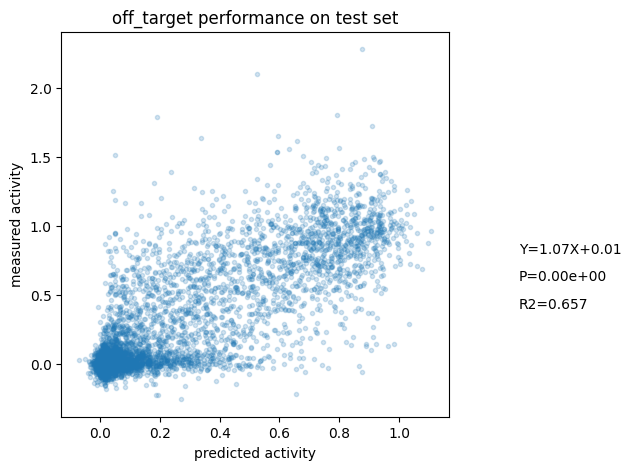

In [52]:
# Предсказания
pre_act = model_float.predict(X_test).ravel()
true_act = y_test.ravel()

# Пример: построим scatter-диаграмму предсказаний vs истинных значений
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(pre_act, true_act, marker='.', alpha=.2)
a, b, r_value, p_value, std_err = stats.linregress(pre_act, true_act)

ax.set_xlabel('predicted activity')
ax.set_ylabel('measured activity')
ax.set_title('off_target performance on test set')

plt.text(1.4, 0.8, f'Y={a:.2f}X+{b:.2f}')
plt.text(1.4, 0.6, f'P={p_value:.2e}')
plt.text(1.4, 0.4, f'R2={r_value*r_value:.3f}')

plt.show()

In [53]:
results_df, mse, mae, r2 = evaluate_regression_model(model_float, X_test, y_test)

165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0251 - mean_absolute_error: 0.1490
Test Loss (MSE): 0.02532
Test MAE: 0.15111
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step

Regression Metrics:
Mean Squared Error (MSE): 0.05347
Mean Absolute Error (MAE): 0.15111
R² Score: 0.64948


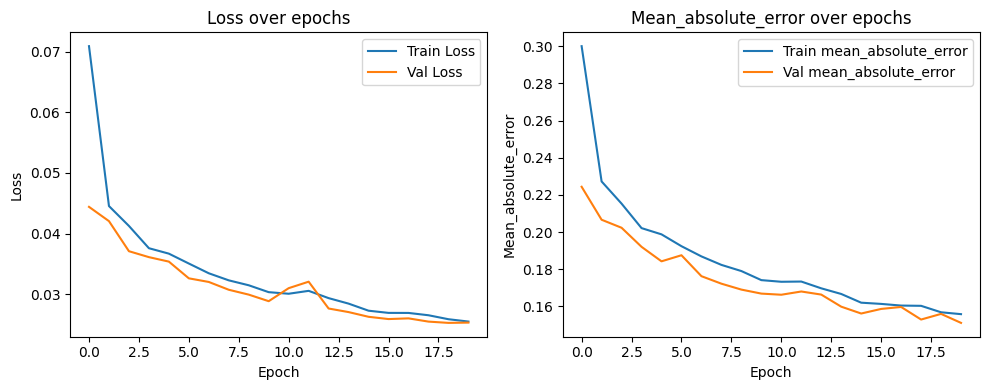

In [54]:
plot_learning_curves(history, metric='mean_absolute_error')

### CRISPR-BERT embeddings

In [13]:
# Словарь кодировки пар оснований
base_pair_dict = {
    "AA": 2, "AC": 3, "AG": 4, "AT": 5,
    "CA": 6, "CC": 7, "CG": 8, "CT": 9,
    "GA": 10, "GC": 11, "GG": 12, "GT": 13,
    "TA": 14, "TC": 15, "TG": 16, "TT": 17,
    "A_": 18, "_A": 19, "C_": 20, "_C": 21,
    "G_": 22, "_G": 23, "T_": 24, "_T": 25
}

def BERT_encode(sequence_pairs, max_length=26):
    """
    Кодирует список sgRNA-ДНК пар в числовые последовательности для подачи в BERT.
    
    :param sequence_pairs: список кортежей (sgRNA, DNA)
    :param max_length: максимальная длина последовательности (например, 26)
    :return: numpy массивы с токенами и позиционной информацией
    """
    encoded_sequences = []
    
    for sgRNA, DNA in sequence_pairs:
        assert len(sgRNA) == len(DNA), "Длины sgRNA и DNA должны совпадать"
        
        tokens = [0]  # [CLS] в начале
        for r, d in zip(sgRNA, DNA):
            pair = r + d
            tokens.append(base_pair_dict.get(pair, 1))  # 1 - если неизвестная пара
        tokens.append(1)  # [SEP] в конце

        # Дополнение до max_length
        while len(tokens) < max_length:
            tokens.append(0)  # [PAD]
        
        encoded_sequences.append(tokens[:max_length])  # Обрезка, если больше max_length

    return np.array(encoded_sequences, dtype=np.int32)

In [21]:
from keras_bert import load_trained_model_from_checkpoint
config_path     = r'weight\bert_weight\uncased_L-2_H-256_A-4\bert_config.json' 
checkpoint_path = r'weight\bert_weight\uncased_L-2_H-256_A-4\bert_model.ckpt'
bert_model = load_trained_model_from_checkpoint(config_path, checkpoint_path, trainable=False)

NotImplementedError: Iterating over a symbolic KerasTensor is not supported.

In [22]:
import os

config_path     = r'weight\bert_weight\uncased_L-2_H-256_A-4\bert_config.json'
checkpoint_path = r'weight\bert_weight\uncased_L-2_H-256_A-4\bert_model.ckpt'

assert os.path.exists(config_path), f"Файл {config_path} не найден"
assert os.path.exists(checkpoint_path + ".index"), f"Файл {checkpoint_path}.index не найден"
assert os.path.exists(checkpoint_path + ".data-00000-of-00001"), f"Файл {checkpoint_path}.data-00000-of-00001 не найден"

print("Все файлы найдены, можно загружать BERT.")


Все файлы найдены, можно загружать BERT.


In [24]:
from keras_bert import load_trained_model_from_checkpoint

bert_model = load_trained_model_from_checkpoint(
    config_path, 
    checkpoint_path, 
    training=False,  # или trainable=False
    seq_len=None  # Позволяет работать с переменной длиной
)

bert_model.summary()



NotImplementedError: Iterating over a symbolic KerasTensor is not supported.

In [ ]:
# Пример входных данных (список пар sgRNA-ДНК)
sequence_pairs = [("AGCTAGCTAGCTAGCTAGCTAGCT", "TCGATCGATCGATCGATCGATCGA")]

# Кодируем
bert_inputs = BERT_encode(sequence_pairs)

# Подключаем к BERT-модели
preds = bert_model.predict([bert_inputs, np.zeros_like(bert_inputs)])  # Подаём маску из нулей

In [25]:
import tensorflow as tf
print(tf.__version__)


2.18.0


### CNN, SeQuant embeddings

In [68]:
# 📌 Определяем названия колонок
genome_features = [f"genome_feature_{i}" for i in range(43)]
sgrna_features = [f"sgrna_feature_{i}" for i in range(43)]
target = "mean relative gamma"

# 📌 Извлекаем данные
X_genome = df[genome_features].to_numpy()  # (samples, 43)
X_sgrna = df[sgrna_features].to_numpy()  # (samples, 43)
y = df[target].to_numpy()  # Целевая переменная

# 📌 Разделяем данные на train/test
X_genome_train, X_genome_test, X_sgrna_train, X_sgrna_test, y_train, y_test = train_test_split(
    X_genome, X_sgrna, y, test_size=0.2, random_state=42
)

# 📌 Проверяем размерности
print(f"X_genome_train shape: {X_genome_train.shape}")  # (samples, 43)
print(f"X_sgrna_train shape: {X_sgrna_train.shape}")  # (samples, 43)
print(f"y_train shape: {y_train.shape}")  # (samples,)

X_genome_train shape: (20998, 43)
X_sgrna_train shape: (20998, 43)
y_train shape: (20998,)


In [69]:
# 📌 Входной слой для genome эмбеддингов
input_genome = Input(shape=(43,), name="genome_input")
x1 = Dense(64, activation='relu')(input_genome)
x1 = Dropout(0.3)(x1)
x1 = Dense(32, activation='relu')(x1)
x1 = Dropout(0.3)(x1)

# 📌 Входной слой для sgrna эмбеддингов
input_sgrna = Input(shape=(43,), name="sgrna_input")
x2 = Dense(64, activation='relu')(input_sgrna)
x2 = Dropout(0.3)(x2)
x2 = Dense(32, activation='relu')(x2)
x2 = Dropout(0.3)(x2)

# 📌 Объединяем два потока
merged = Concatenate()([x1, x2])
x = Dense(64, activation='relu')(merged)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.3)(x)

# 📌 Выходной слой (регрессия)
output = Dense(1, activation='linear', name="output")(x)

# 📌 Создаем модель
model = Model(inputs=[input_genome, input_sgrna], outputs=output)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# 📌 Вывод структуры модели
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ genome_input        │ (None, 43)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sgrna_input         │ (None, 43)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 64)        │      2,816 │ genome_input[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 64)        │      2,816 │ sgrna_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 64)        │          0 │ dense_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 64)        │          0 │ dense_13[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 32)        │      2,080 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 32)        │      2,080 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 32)        │          0 │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 32)        │          0 │ dense_14[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 64)        │          0 │ dropout_4[0][0],  │
│ (Concatenate)       │                   │            │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 64)        │      4,160 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 64)        │          0 │ dense_15[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 32)        │      2,080 │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 32)        │          0 │ dense_16[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │         33 │ dropout_8[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 16,065 (62.75 KB)

 Trainable params: 16,065 (62.75 KB)

 Non-trainable params: 0 (0.00 B)

In [70]:
history = model.fit(
    [X_genome_train, X_sgrna_train], y_train,
    epochs=20, batch_size=32, validation_split=0.2, verbose=1
)

Epoch 1/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 4.6866 - mae: 1.1375 - val_loss: 0.1799 - val_mae: 0.2822
Epoch 2/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1855 - mae: 0.3436 - val_loss: 0.1566 - val_mae: 0.2973
Epoch 3/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1612 - mae: 0.3308 - val_loss: 0.1503 - val_mae: 0.3072
Epoch 4/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1577 - mae: 0.3333 - val_loss: 0.1484 - val_mae: 0.3129
Epoch 5/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1528 - mae: 0.3312 - val_loss: 0.1473 - val_mae: 0.3192
Epoch 6/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1557 - mae: 0.3350 - val_loss: 0.1473 - val_mae: 0.3201
Epoch 7/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1545 - mae: 0.3351 - val_loss: 0.1473 - val_mae: 0.3194
Epoch 8/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1539 - mae: 0.3315 - val_loss: 0.1472 - val_mae: 0.3257
Epoch 9/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - lo

In [71]:
results_df, mse, mae, r2 = evaluate_regression_model(model, [X_genome_test, X_sgrna_test], y_test)

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1550 - mae: 0.3364
Test Loss (MSE): 0.15257
Test MAE: 0.33360
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Regression Metrics:
Mean Squared Error (MSE): 0.15257
Mean Absolute Error (MAE): 0.33360
R² Score: -0.00015


### CNN, encoded_or

In [12]:
# Преобразуем encoded_7channels обратно в матрицу 7×N (для CNN можно оставить 2D)
X = np.array([np.reshape(ch, (4, -1)).T for ch in df['encoded_or']])

# Целевая переменная
y = df['mean relative gamma'].to_numpy()

# Разбиваем на train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}")  # (samples, N, 7)
print(f"y_train shape: {y_train.shape}")  # (samples,)

X_train shape: (20998, 26, 4)
y_train shape: (20998,)


In [13]:
# Входной слой
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

# Сверточный слой для извлечения признаков
x = Conv1D(32, kernel_size=3, activation='relu', padding='same')(input_layer)
x = Flatten()(x)  # Преобразуем в одномерный вектор
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.3)(x)

# Выходной слой (предсказание числового значения)
output_layer = Dense(1, activation='linear')(x)

# Определяем модель
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])  # MSE + MAE

# Вывод структуры модели
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 26, 4)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 26, 32)         │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 832)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        53,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,841 (218.13 KB)

 Trainable params: 55,841 (218.13 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Обучение модели
history = model.fit(
    X_train, y_train, 
    epochs=20, batch_size=32, validation_split=0.2, verbose=1
)

Epoch 1/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 0.1590 - mae: 0.3235

: 

### CNN (encoded_7channels)

In [40]:
# Преобразуем encoded_7channels обратно в матрицу 7×N (для CNN можно оставить 2D)
X = np.array([np.reshape(ch, (7, -1)).T for ch in df['encoded_7channels']])

# Целевая переменная
y = df['mean_relative_gamma'].to_numpy()

# Разбиваем на train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}")  # (samples, N, 7)
print(f"y_train shape: {y_train.shape}")  # (samples,)

X_train shape: (20998, 26, 7)
y_train shape: (20998,)


In [41]:
# Входной слой
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

# Сверточный слой для извлечения признаков
x = Conv1D(32, kernel_size=3, activation='relu', padding='same')(input_layer)
x = Flatten()(x)  # Преобразуем в одномерный вектор
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.3)(x)

# Выходной слой (предсказание числового значения)
output_layer = Dense(1, activation='linear')(x)

# Определяем модель
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])  # MSE + MAE

# Вывод структуры модели
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 26, 7)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 26, 32)         │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 832)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        53,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,129 (219.25 KB)

 Trainable params: 56,129 (219.25 KB)

 Non-trainable params: 0 (0.00 B)

In [42]:
# Обучение модели
history = model.fit(
    X_train, y_train, 
    epochs=20, batch_size=32, validation_split=0.2, verbose=1
)

Epoch 1/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - loss: 0.1279 - mae: 0.2715 - val_loss: 0.0831 - val_mae: 0.2065
Epoch 2/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.0855 - mae: 0.2124 - val_loss: 0.0748 - val_mae: 0.1971
Epoch 3/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 0.0736 - mae: 0.1949 - val_loss: 0.0653 - val_mae: 0.1825
Epoch 4/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.0674 - mae: 0.1851 - val_loss: 0.0609 - val_mae: 0.1709
Epoch 5/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0638 - mae: 0.1781 - val_loss: 0.0587 - val_mae: 0.1692
Epoch 6/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.0584 - mae: 0.1712 - val_loss: 0.0572 - val_mae: 0.1645
Epoch 7/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.0524 - mae: 0.1609 - val_loss: 0.0548 - val_mae: 0.1590
Epoch 8/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.0499 - mae: 0.1572 - val_loss: 0.0555 - val_mae: 0.1633
Epoch 9/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 19

In [43]:
results_df, mse, mae, r2 = evaluate_regression_model(model, X_test, y_test)

165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0524 - mae: 0.1502
Test Loss (MSE): 0.05289
Test MAE: 0.15184
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Regression Metrics:
Mean Squared Error (MSE): 0.05289
Mean Absolute Error (MAE): 0.15184
R² Score: 0.65328


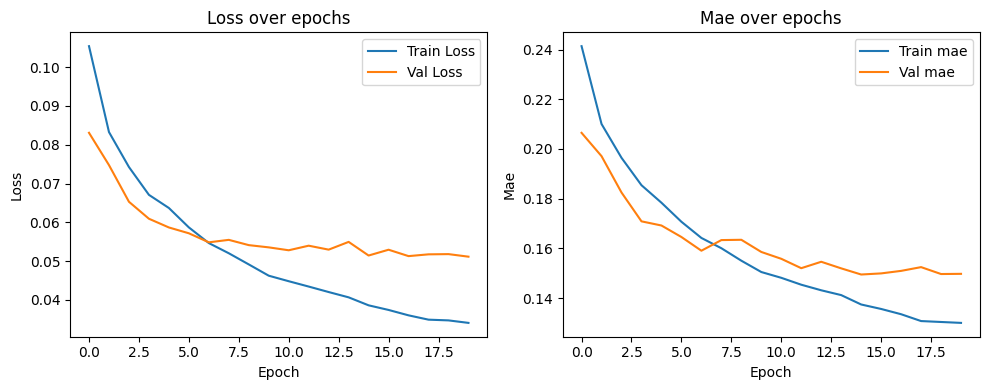

In [47]:
plot_learning_curves(history, metric='mae')

### RNN, encoded_7 + extra

In [6]:
# 📌 Признаки
sequence_features = 'encoded_7channels'  # Матрица 7×N
numerical_features = ['mismatch position', 'mismatch_count', 'gc_genome', 'gc_sgrna']  # Числовые признаки
target = 'mean relative gamma'  # Целевая переменная

# Преобразуем `encoded_7channels` обратно в матрицу 7×N
X_seq = np.array([np.reshape(ch, (7, -1)).T for ch in df[sequence_features]])

# Извлекаем числовые признаки
X_num = df[numerical_features].to_numpy()

# Целевая переменная
y = df[target].to_numpy()

# Разбиваем на train/test
X_seq_train, X_seq_test, X_num_train, X_num_test, y_train, y_test = train_test_split(
    X_seq, X_num, y, test_size=0.2, random_state=42
)

# Проверяем размерности
print(f"X_seq_train shape: {X_seq_train.shape}")  # (samples, N, 7)
print(f"X_num_train shape: {X_num_train.shape}")  # (samples, 4)
print(f"y_train shape: {y_train.shape}")  # (samples,)

X_seq_train shape: (20998, 26, 7)
X_num_train shape: (20998, 4)
y_train shape: (20998,)


In [8]:
# Вход для последовательности (encoded_7channels)
input_seq = Input(shape=(X_seq_train.shape[1], X_seq_train.shape[2]), name="sequence_input")

# Вход для числовых признаков
input_num = Input(shape=(X_num_train.shape[1],), name="numerical_input")

# 📌 RNN часть (LSTM)
x1 = LSTM(64, return_sequences=True)(input_seq)
x1 = LSTM(32)(x1)

# 📌 Полносвязные слои для числовых признаков
x2 = Dense(32, activation='relu')(input_num)
x2 = Dropout(0.3)(x2)

# 📌 Объединяем два потока
merged = Concatenate()([x1, x2])
x = Dense(64, activation='relu')(merged)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.3)(x)

# 📌 Выходной слой (регрессия)
output = Dense(1, activation='linear', name="output")(x)

# Создаем модель
model = Model(inputs=[input_seq, input_num], outputs=output)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Вывод структуры модели
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ sequence_input      │ (None, 26, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ numerical_input     │ (None, 4)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 26, 64)    │     18,432 │ sequence_input[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │        160 │ numerical_input[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 32)        │     12,416 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 32)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64)        │          0 │ lstm_1[0][0],     │
│ (Concatenate)       │                   │            │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      4,160 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      2,080 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │         33 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 37,281 (145.63 KB)

 Trainable params: 37,281 (145.63 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
history = model.fit(
    [X_seq_train, X_num_train], y_train,
    epochs=20, batch_size=32, validation_split=0.2, verbose=1
)

Epoch 1/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - loss: 1.0169 - mae: 0.5456 - val_loss: 0.1339 - val_mae: 0.2455
Epoch 2/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 0.1178 - mae: 0.2535 - val_loss: 0.1193 - val_mae: 0.2487
Epoch 3/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 0.1121 - mae: 0.2537 - val_loss: 0.1180 - val_mae: 0.2471
Epoch 4/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 0.1060 - mae: 0.2445 - val_loss: 0.1084 - val_mae: 0.2476
Epoch 5/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 0.1029 - mae: 0.2439 - val_loss: 0.0991 - val_mae: 0.2425
Epoch 6/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 0.1059 - mae: 0.2480 - val_loss: 0.1071 - val_mae: 0.2440
Epoch 7/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 0.1045 - mae: 0.2455 - val_loss: 0.1127 - val_mae: 0.2470
Epoch 8/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 0.1030 - mae: 0.2433 - val_loss: 0.1082 - val_mae: 0.2472
Epoch 9/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 11s 20m

In [14]:
results_df, mse, mae, r2 = evaluate_regression_model(model, [X_seq_test, X_num_test], y_test)

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1095 - mae: 0.2374
Test Loss (MSE): 0.10911
Test MAE: 0.23721
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Regression Metrics:
Mean Squared Error (MSE): 0.10911
Mean Absolute Error (MAE): 0.23721
R² Score: 0.28473


### CNN, encoded_7channels + extra

In [15]:
# 📌 Признаки
sequence_features = 'encoded_7channels'  # Матрица 7×N
numerical_features = ['mismatch position', 'mismatch_count', 'gc_genome', 'gc_sgrna']  # Числовые признаки
target = 'mean relative gamma'  # Целевая переменная

# Преобразуем `encoded_7channels` обратно в матрицу 7×N
X_seq = np.array([np.reshape(ch, (7, -1)).T for ch in df[sequence_features]])

# Извлекаем числовые признаки
X_num = df[numerical_features].to_numpy()

# Целевая переменная
y = df[target].to_numpy()

# Разбиваем на train/test
X_seq_train, X_seq_test, X_num_train, X_num_test, y_train, y_test = train_test_split(
    X_seq, X_num, y, test_size=0.2, random_state=42
)

# Проверяем размерности
print(f"X_seq_train shape: {X_seq_train.shape}")  # (samples, N, 7)
print(f"X_num_train shape: {X_num_train.shape}")  # (samples, 4)
print(f"y_train shape: {y_train.shape}")  # (samples,)

X_seq_train shape: (20998, 26, 7)
X_num_train shape: (20998, 4)
y_train shape: (20998,)


In [19]:
# Вход для последовательности (encoded_7channels)
input_seq = Input(shape=(X_seq_train.shape[1], X_seq_train.shape[2]), name="sequence_input")

# Вход для числовых признаков
input_num = Input(shape=(X_num_train.shape[1],), name="numerical_input")

# 📌 CNN часть (Conv1D + MaxPooling)
x1 = Conv1D(64, kernel_size=3, activation='relu', padding='same')(input_seq)
x1 = MaxPooling1D(pool_size=2)(x1)
x1 = Conv1D(32, kernel_size=3, activation='relu', padding='same')(x1)
x1 = Flatten()(x1)  # Преобразуем в одномерный вектор

# 📌 Полносвязные слои для числовых признаков
x2 = Dense(32, activation='relu')(input_num)
x2 = Dropout(0.3)(x2)

# 📌 Объединяем два потока
merged = Concatenate()([x1, x2])
x = Dense(64, activation='relu')(merged)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.3)(x)

# 📌 Выходной слой (регрессия)
output = Dense(1, activation='linear', name="output")(x)

# Создаем модель
model = Model(inputs=[input_seq, input_num], outputs=output)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Вывод структуры модели
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ sequence_input      │ (None, 26, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 26, 64)    │      1,408 │ sequence_input[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 13, 64)    │          0 │ conv1d_1[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ numerical_input     │ (None, 4)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 13, 32)    │      6,176 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 32)        │        160 │ numerical_input[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 416)       │          0 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 32)        │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 448)       │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │     28,736 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 64)        │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 32)        │      2,080 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 32)        │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │         33 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,593 (150.75 KB)

 Trainable params: 38,593 (150.75 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    [X_seq_train, X_num_train], y_train,
    epochs=20, batch_size=32, validation_split=0.2, verbose=1
)

Epoch 1/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.1385 - mae: 0.2696 - val_loss: 0.1049 - val_mae: 0.2342
Epoch 2/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0954 - mae: 0.2302 - val_loss: 0.0998 - val_mae: 0.2224
Epoch 3/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0853 - mae: 0.2150 - val_loss: 0.0777 - val_mae: 0.2034
Epoch 4/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0759 - mae: 0.1993 - val_loss: 0.0746 - val_mae: 0.1906
Epoch 5/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0731 - mae: 0.1922 - val_loss: 0.0707 - val_mae: 0.1890
Epoch 6/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0670 - mae: 0.1829 - val_loss: 0.0684 - val_mae: 0.1859
Epoch 7/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0673 - mae: 0.1827 - val_loss: 0.0657 - val_mae: 0.1806
Epoch 8/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0635 - mae: 0.1753 - val_loss: 0.0764 - val_mae: 0.1852
Epoch 9/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - lo

In [23]:
results_df, mse, mae, r2 = evaluate_regression_model(model, [X_seq_test, X_num_test], y_test)

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0596 - mae: 0.1665
Test Loss (MSE): 0.05947
Test MAE: 0.16765
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Regression Metrics:
Mean Squared Error (MSE): 0.05947
Mean Absolute Error (MAE): 0.16765
R² Score: 0.61017


# Classification

## CNN

### embeddings

In [69]:
# Удаляем строки, где нет хотя бы одного эмбеддинга
df_cleaned = df.dropna(subset=[f'target_feature_{i}' for i in range(43)] + 
                               [f'off_target_feature_{i}' for i in range(43)]).reset_index(drop=True)

print(f"Размер после очистки: {df_cleaned.shape}")  # Должно быть (20319, 93), если всё норм

target_features = [f'target_feature_{i}' for i in range(43)]
off_target_features = [f'off_target_feature_{i}' for i in range(43)]

X_target = df_cleaned[target_features].to_numpy()
X_off_target = df_cleaned[off_target_features].to_numpy()
y = df_cleaned['is_off_target'].fillna(0).to_numpy()

# Разделяем данные
X_target_train, X_target_test, X_off_train, X_off_test, y_train, y_test = train_test_split(
    X_target, X_off_target, y, test_size=0.2, random_state=42, stratify=y
)

print(f"X_target_train shape: {X_target_train.shape}")
print(f"X_off_train shape: {X_off_train.shape}")
print(f"y_train shape: {y_train.shape}")

Размер после очистки: (20319, 93)
X_target_train shape: (16255, 43)
X_off_train shape: (16255, 43)
y_train shape: (16255,)


In [70]:
# Вход для target
input_target = Input(shape=(43,), name='target_input')

# Вход для potential_off_target
input_off_target = Input(shape=(43,), name='off_target_input')

# Полносвязные слои для target
x1 = Dense(64, activation='relu')(input_target)
x1 = Dropout(0.3)(x1)

# Полносвязные слои для potential_off_target
x2 = Dense(64, activation='relu')(input_off_target)
x2 = Dropout(0.3)(x2)

# Объединяем два входа
merged = Concatenate()([x1, x2])
x = Dense(128, activation='relu')(merged)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)

# Выходной слой (теперь он правильно связан с моделью)
output = Dense(1, activation='sigmoid', name='output')(x)

# Определяем модель
model = Model(inputs=[input_target, input_off_target], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Вывод структуры модели
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ target_input        │ (None, 43)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ off_target_input    │ (None, 43)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 64)        │      2,816 │ target_input[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 64)        │      2,816 │ off_target_input… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_16          │ (None, 64)        │          0 │ dense_16[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 64)        │          0 │ dense_17[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 128)       │          0 │ dropout_16[0][0], │
│ (Concatenate)       │                   │            │ dropout_17[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 128)       │     16,512 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 128)       │          0 │ dense_18[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 64)        │      8,256 │ dropout_18[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_19          │ (None, 64)        │          0 │ dense_19[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │         65 │ dropout_19[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 30,465 (119.00 KB)

 Trainable params: 30,465 (119.00 KB)

 Non-trainable params: 0 (0.00 B)

In [74]:
# Преобразуем список классов в numpy массив
class_weights = compute_class_weight(class_weight='balanced', classes=np.array([0, 1]), y=y_train)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

print(f"Class Weights: {class_weight_dict}")  # Посмотрим, какие веса

# Обучаем с учетом весов
history = model.fit(
    [X_target_train, X_off_train], y_train, 
    epochs=20, batch_size=32, validation_split=0.2, 
    class_weight=class_weight_dict, verbose=1
)

Class Weights: {0: np.float64(0.502970480846587), 1: np.float64(84.66145833333333)}
Epoch 1/20
407/407 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.7464 - loss: 5.6945 - val_accuracy: 0.0920 - val_loss: 0.8014
Epoch 2/20
407/407 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.5471 - loss: 1.1978 - val_accuracy: 0.9945 - val_loss: 0.3656
Epoch 3/20
407/407 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.5855 - loss: 1.1828 - val_accuracy: 0.0584 - val_loss: 0.8825
Epoch 4/20
407/407 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.2962 - loss: 0.7089 - val_accuracy: 0.0821 - val_loss: 0.7433
Epoch 5/20
407/407 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.3202 - loss: 0.8664 - val_accuracy: 0.9923 - val_loss: 0.6414
Epoch 6/20
407/407 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.3410 - loss: 0.6513 - val_accuracy: 0.0892 - val_loss: 0.7275
Epoch 7/20
407/407 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.1937 - loss: 0.7016 - val_accuracy: 0.0806 - val_loss: 0.6997
Epoch 8/20
407/

In [75]:
results_df, annotated_cm = evaluate_model(model, [X_target_test, X_off_test], y_test, beta=1, threshold=0.4)

127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0813 - loss: 0.7434
Test Loss: 0.74396
Test Accuracy: 0.07899
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Metrics:
Precision: 0.00635
Recall: 1.00000
F1-score: 0.01263
F-beta (1): 0.01263
Threshold used: 0.4

Results DataFrame (first 5 rows):
   y_test  y_pred_proba  y_pred prediction_is_true
0       0      0.551689       1                 No
1       0      0.551689       1                 No
2       0      0.551689       1                 No
3       0      0.551689       1                 No
4       0      0.551689       1                 No

Annotated Confusion Matrix:
                       Predicted No (0)          Predicted Yes (1)
Actual No (0)   TN (True Negative): 287  FP (False Positive): 3753
Actual Yes (1)   FN (False Negative): 0     TP (True Positive): 24


### encoded_7channels + 3 extra

In [38]:
df['encoded_7channels'] = df['encoded_7channels'].apply(lambda x: x.reshape(23, 7))

In [39]:
# Входы
sequence_input = Input(shape=(23, 7), name='sequence_input')  # N = длина последовательности
additional_input = Input(shape=(3,), name='additional_input')  # gc_content, mismatch_count,

# CNN для последовательностей
x = Conv1D(32, kernel_size=3, activation='relu')(sequence_input)
x = Flatten()(x)

# Полносвязный слой для дополнительных признаков
w = Dense(16, activation='relu')(additional_input)

# Объединяем
combined = Concatenate()([x, w])
z = Dense(64, activation='relu')(combined)
output = Dense(1, activation='sigmoid')(z)

# Финальная модель
model = tf.keras.Model(inputs=[sequence_input, additional_input], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [41]:
# X_sequences = np.array([encoded.flatten() for encoded in df['encoded_7channels']])  # Вход для CNN
X_sequences = np.array(df['encoded_7channels'].tolist())  # Вход для CNN
X_additional = df[['gc_target', 'gc_off_target', 'mismatch_count']].to_numpy()  # Доп. признаки
y = df['is_off_target'].to_numpy()

In [42]:
X_seq_train, X_seq_test, X_add_train, X_add_test, y_train, y_test = train_test_split(
    X_sequences, X_additional, y, test_size=0.2, random_state=42
)

# Обучение модели на тренировочных данных
model.fit(
    [X_seq_train, X_add_train],
    y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

Epoch 1/20
407/407 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9996 - loss: 0.0014 - val_accuracy: 0.9982 - val_loss: 0.0052
Epoch 2/20
407/407 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9994 - loss: 0.0016 - val_accuracy: 0.9963 - val_loss: 0.0133
Epoch 3/20
407/407 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9998 - loss: 9.8313e-04 - val_accuracy: 0.9982 - val_loss: 0.0063
Epoch 4/20
407/407 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 1.0000 - loss: 9.2333e-05 - val_accuracy: 0.9982 - val_loss: 0.0064
Epoch 5/20
407/407 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 1.0000 - loss: 4.8750e-05 - val_accuracy: 0.9982 - val_loss: 0.0079
Epoch 6/20
407/407 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 1.0000 - loss: 2.2468e-05 - val_accuracy: 0.9982 - val_loss: 0.0068
Epoch 7/20
407/407 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 1.0000 - loss: 1.8742e-05 - val_accuracy: 0.9982 - val_loss: 0.0074
Epoch 8/20
407/407 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 1.0000 - loss: 1.048

In [43]:
# Оценка модели на тестовых данных
results_df, annotated_cm = evaluate_classification_model(model, [X_seq_test, X_add_test], y_test)

127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9987 - loss: 0.0028
Test Loss: 0.00198
Test Accuracy: 0.99902
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Metrics:
Precision: 0.95455
Recall: 0.87500
F1-score: 0.91304
F-beta (2): 0.88983
Threshold used: 0.5

Results DataFrame (first 5 rows):
   y_test  y_pred_proba  y_pred prediction_is_true
0       0  9.797002e-33       0                Yes
1       0  6.778435e-22       0                Yes
2       0  4.551552e-31       0                Yes
3       0  1.131322e-29       0                Yes
4       0  1.170316e-27       0                Yes

Annotated Confusion Matrix:
                        Predicted No (0)       Predicted Yes (1)
Actual No (0)   TN (True Negative): 4039  FP (False Positive): 1
Actual Yes (1)    FN (False Negative): 3  TP (True Positive): 21


### Only encoded_7channels

In [44]:
# Преобразуем данные
X = np.array([np.reshape(ch, (7, -1)).T for ch in df['encoded_7channels']])  # Преобразуем flattened массивы обратно в матрицы 7xN
y = np.array(df['is_off_target'])  # Бинарная целевая переменная

# Разделение на тренировочный и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Определяем параметры входа
input_shape = X_train.shape[1:]  # (длина последовательности, 7 каналов)

In [14]:
unique, frequency = np.unique(y_test, return_counts = True)

print("Unique Values:", unique)
print("Frequency Values:", frequency)

Unique Values: [0 1]
Frequency Values: [4040   24]


In [45]:
# Создаем модель CNN
model = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape),
    BatchNormalization(),
    Dropout(0.3),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Для бинарной классификации
])

# Компилируем модель
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Обучаем модель
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/20


d:\polina\CRISPR\crispr\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


407/407 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9747 - loss: 0.0858 - val_accuracy: 0.9908 - val_loss: 0.0670
Epoch 2/20
407/407 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9948 - loss: 0.0200 - val_accuracy: 0.9945 - val_loss: 0.0185
Epoch 3/20
407/407 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9961 - loss: 0.0113 - val_accuracy: 0.9945 - val_loss: 0.0161
Epoch 4/20
407/407 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9969 - loss: 0.0085 - val_accuracy: 0.9942 - val_loss: 0.0171
Epoch 5/20
407/407 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9970 - loss: 0.0073 - val_accuracy: 0.9942 - val_loss: 0.0142
Epoch 6/20
407/407 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9977 - loss: 0.0072 - val_accuracy: 0.9938 - val_loss: 0.0175
Epoch 7/20
407/407 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9973 - loss: 0.0055 - val_accuracy: 0.9948 - val_loss: 0.0158
Epoch 8/20
407/407 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9969 - loss: 0.0073 - val_accuracy: 0.9935 - val_

In [46]:
results_df, annotated_cm = evaluate_classification_model(model, [X_seq_test, X_add_test], y_test)

d:\polina\CRISPR\crispr\venv\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_18
Received: inputs=('Tensor(shape=(32, 23, 7))', 'Tensor(shape=(32, 3))')
  warnings.warn(msg)


127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9791 - loss: 0.0533
Test Loss: 0.05452
Test Accuracy: 0.98007
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Metrics:
Precision: 0.13924
Recall: 0.45833
F1-score: 0.21359
F-beta (2): 0.31429
Threshold used: 0.5

Results DataFrame (first 5 rows):
   y_test  y_pred_proba  y_pred prediction_is_true
0       0  2.009036e-15       0                Yes
1       0  1.195813e-10       0                Yes
2       0  6.660504e-10       0                Yes
3       0  4.172120e-16       0                Yes
4       0  2.814111e-09       0                Yes

Annotated Confusion Matrix:
                        Predicted No (0)        Predicted Yes (1)
Actual No (0)   TN (True Negative): 3972  FP (False Positive): 68
Actual Yes (1)   FN (False Negative): 13   TP (True Positive): 11


Нужно свести к минимуму FN

# Функции

In [ ]:
# def train_and_evaluate_model(df: pd.DataFrame, encoding_function, model) -> None:
#     """
#     Обучает модель с использованием заданной функции кодирования и выводит R^2, MSE, предсказания и тестовые значения.

#     :param df: Датафрейм с колонками genome input, sgRNA input и mean relative gamma
#     :param encoding_function: Функция кодирования для использования
#     """
#     # Кодирование данных
#     df['encoded'] = df.apply(
#         lambda row: encoding_function(row['genome input'], row['sgRNA input']).flatten(),
#         axis=1
#     )

#     # Подготовка данных для обучения
#     X = np.vstack(df['encoded'].values)  # Преобразование списка массивов в 2D массив
#     y = df['mean relative gamma']

#     # Разделяем данные на обучающую и тестовую выборки
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#     # Обучение модели
#     model.fit(X_train, y_train)

#     # Предсказания
#     y_pred = model.predict(X_test)

#     # Вычисление метрик
#     r2_score = model.score(X_test, y_test)
#     mse = mean_squared_error(y_test, y_pred)
#     mae = mean_absolute_error(y_test, y_pred)

#     # Вывод результатов
#     print(f"R^2 Score: {r2_score:.4f}")
#     print(f"Mean Squared Error: {mse:.4f}")
#     print(f"Mean Absolute Error: {mae:.4f}")
#     print("Predictions vs Actual:")
#     for pred, actual in zip(y_pred, y_test):
#         print(f"Predicted: {pred:.4f}, Actual: {actual:.4f}")